In [1]:
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

(472, 384, 3)


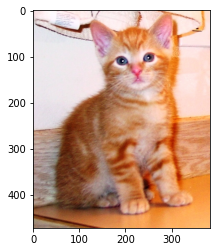

In [2]:
cat = cv2.imread('DATA/CATS_DOGS/train/CAT/1853.jpg')
cat = cv2.cvtColor(cat, cv2.COLOR_BGR2RGB)
print(cat.shape)
plt.imshow(cat)

(320, 350, 3)


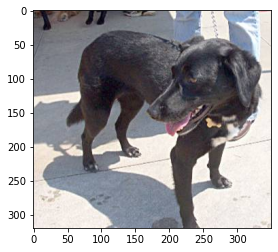

In [3]:
dog = cv2.imread('DATA/CATS_DOGS/train/DOG/400.jpg')
dog = cv2.cvtColor(dog, cv2.COLOR_BGR2RGB)
print(dog.shape)
plt.imshow(dog)

In [4]:
print(cat.max())
print(dog.max())
print(cat.min())
print(dog.min())

255
255
0
0


In [5]:
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [6]:
image_gen = ImageDataGenerator(rotation_range=30,
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              rescale=1/255,
                              shear_range=0.2,
                              horizontal_flip=True,
                              fill_mode='nearest')

image_gen

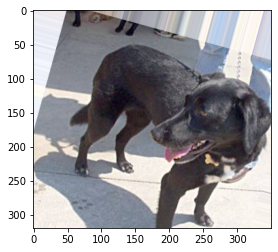

In [7]:
plt.imshow(image_gen.random_transform(dog))

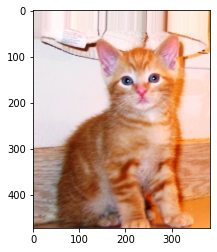

In [8]:
plt.imshow(image_gen.random_transform(cat))

In [9]:
print(image_gen.flow_from_directory('DATA/CATS_DOGS/train/'))
print(image_gen.flow_from_directory('DATA/CATS_DOGS/test/'))

Found 18743 images belonging to 2 classes.
Found 6251 images belonging to 2 classes.


## Building Model

In [10]:
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten,  Conv2D, MaxPooling2D, Dense

In [11]:
input_shape = (150, 150, 3)

In [12]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (3,3), input_shape = input_shape, activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

##
model.add(Conv2D(filters = 64, kernel_size = (3,3), input_shape = input_shape, activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

##
model.add(Conv2D(filters = 64, kernel_size = (3,3), input_shape = input_shape, activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))


model.add(Flatten())

model.add(Dense(128))
model.add(Activation('relu'))

model.add(Dropout(0.5))  #Turn's Neuron's Off - 50% and reduce overfitting

model.add(Dense(1))  #Output Neuron
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 18496)            

## Training the Model

In [14]:
batch_size = 16

train_image_gen = image_gen.flow_from_directory('DATA/CATS_DOGS/train/',
                                                target_size=input_shape[:2],
                                                batch_size = batch_size,
                                                class_mode = 'binary')


test_image_gen = image_gen.flow_from_directory('DATA/CATS_DOGS/test/',
                                                target_size=input_shape[:2],
                                                batch_size = batch_size,
                                                class_mode = 'binary')

print(train_image_gen)
print(test_image_gen)

Found 18743 images belonging to 2 classes.
Found 6251 images belonging to 2 classes.


In [15]:
train_image_gen.class_indices

{'CAT': 0, 'DOG': 1}

In [16]:
import warnings
warnings.filterwarnings("ignore")

results = model.fit_generator(train_image_gen,
                              epochs=1,
                              steps_per_epoch=150,
                              validation_data=test_image_gen,
                             validation_steps=12)

Epoch 1/1
150/150 [==============================] - 79s 527ms/step - loss: 0.6952 - accuracy: 0.5225 - val_loss: 0.6811 - val_accuracy: 0.5000


In [17]:
print(results.history['accuracy'])
print(results.history['loss'])
print(results.history['val_loss'])
print(results.history['val_accuracy'])

[0.5225]
[0.6951967263221741]
[0.6811113357543945]
[0.5]


## LOADING ALREADY TRAINED MODEL ON 100 EPOCHS

In [18]:
from keras.models import load_model

In [19]:
new_model = load_model('DATA/cat_dog_100epochs.h5')

## Predicting on a New Image which model has unseen

In [20]:
from keras.preprocessing import image

In [21]:
#Loading Images from Test Data for Testing
cat_file = 'DATA/CATS_DOGS/test/CAT/9379.jpg'
dog_file = 'DATA/CATS_DOGS/test/DOG/9510.jpg'


#resize the image
cat_img = image.load_img(cat_file, target_size=(150, 150))
dog_img = image.load_img(dog_file, target_size=(150, 150))


#convert to array
cat_img = image.img_to_array(cat_img)
dog_img = image.img_to_array(dog_img)


#check shape
print('Resized Cat', cat_img.shape)
print('Resized Dog', dog_img.shape)

Resized Cat (150, 150, 3)
Resized Dog (150, 150, 3)


## STEP1. Dimensions are (150,150,3) - Change to (1,150,150,3)
#### Changing because neural network thinks it a batch of 1 image

In [22]:
import numpy as np

#Upon rerunning below two expand codes again and again dimensions change, please note this step
cat_img = np.expand_dims(cat_img, axis = 0)
dog_img = np.expand_dims(dog_img, axis = 0)  

print('Expanded Cat', cat_img.shape)
print('Expanded Dog', dog_img.shape)

Expanded Cat (1, 150, 150, 3)
Expanded Dog (1, 150, 150, 3)


In [23]:
cat_img = cat_img/255
dog_img = dog_img/255

In [24]:
train_image_gen.class_indices

{'CAT': 0, 'DOG': 1}

## Predict 
### if Cat - 0, Dog - 1

In [25]:
pred1 = new_model.predict(cat_img)
pred2 = new_model.predict(dog_img)

print(pred1)
print(pred2)
print('\n')
print(new_model.predict_classes(cat_img))
print(new_model.predict_classes(dog_img))

[[0.42493135]]
[[0.9999361]]


[[0]]
[[1]]


## Checking the inputs provided

Cat Image Shape (374, 500, 3)


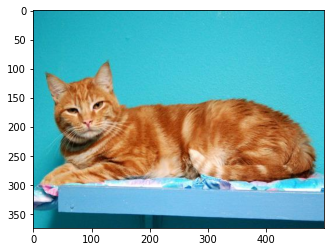

In [26]:
cat_file = cv2.imread(cat_file)
cat_file = cv2.cvtColor(cat_file, cv2.COLOR_BGR2RGB)
print('Cat Image Shape', cat_file.shape)
plt.imshow(cat_file)

Dog Image Shape (500, 374, 3)


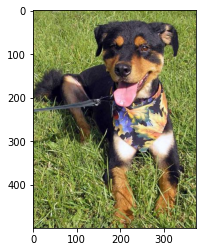

In [27]:
dog_file = cv2.imread(dog_file)
dog_file = cv2.cvtColor(dog_file, cv2.COLOR_BGR2RGB)
print('Dog Image Shape', dog_file.shape)
plt.imshow(dog_file)

## THANK YOU